## Scrape data

In [2]:
'''
Imports modules and libraries needed for web scraping! 
'''
import time #for pausing the scrap
from bs4 import BeautifulSoup #for reading and parsing html
import requests #for requesting a link's html code
from tqdm import tqdm #for progress bar to keep track of iterator time estimate
import re #regular expression for cleaning text
from nltk.tokenize import word_tokenize #for tokenising string into bag of words!

# for wordcloud
from wordcloud import WordCloud
from bidi.algorithm import get_display

# general
import pandas as pd 
import numpy as np
import pickle
import matplotlib.pyplot as plt

# identification to scraped websites
headers = {"user-agent" : "Chrome/84.6.35.5045 (Windows NT 10.0; Win64; x64)",
            "from": "Student working on a university project.)"}

In [382]:
'''
This code goes through a webpage of Walla news archive in the format
'https://news.walla.co.il/archive/1?year=2020&month=3&page=1' after it was parsed by BeautifulSoup
and extracts the titles, subtitles, reporter, date, and links of all 50 articles in the page.
'''

def extract_titles(soup): 

    # an array that will contain all new articles for the page
    page_rows = []
    
    # find the part of the page with all article links
    all_content = soup.find("div", class_="css-18xwv1d")

    # get all links to items
    all_links = all_content.find_all("a",href=True)
    link_urls = [l['href'] for l in all_links]
        
    # Look into all article 'boxes' in the page
    all_groupings = all_content.find_all("div", class_="content")

    # for each article
    for i, grouping in enumerate(all_groupings):
        # get title, subtitle, reporter name, and date publisjed
        title = grouping.find("h3").get_text()
        subtitle = grouping.find("p").get_text()
        reporter = grouping.find('div', class_='author').get_text()
        date = grouping.find('div', class_='pub-date').get_text()
        
        # make a data dictionary that will be written into the csv
        row = { "date": date,
                "title": title,
                "subtitle": subtitle,
                "reporter": reporter,
                "link": link_urls[i]}
        
        # fix the first row's reporter name which is not extracted simply by using the get text on the div
        if i==0:
            row['reporter'] = ''.join(e for e in t if (e==' ' or (not e.islower() and e.isalnum() and not e.isnumeric())))
        
        page_rows.append(row)
        
    return(page_rows)

In [383]:
'''
This code finds all of the news pages of a given year. Every page has 50 articles and
a link to the next page, except for the last one. This block of code visits the first
page of the category, scrapes it using the function above, then finds the link to the 
next page and visits it until all pages for that year are scraped.  
'''
# an array that will contain the scraped dataset
all_rows=[]

# an array to hold page URLs to visit
pages=[]

# A counter to monitor which URL should be visited next
counter = 0

# for each month
for m in tqdm(range(1,13)):
    # set up the first URL based on the month, page=1
    start_page = 'https://news.walla.co.il/archive/1?year=2019&month='+str(m)+'&page=1'
    
    # add it to the list of pages to scrape
    pages.append(start_page)
    
    while pages[counter]: # while there are still pages left to scrape

        # rest scraper for a long time to be safe
        time.sleep(11)

        # request the page html
        #print('scraping:', pages[counter])
        page = requests.get(pages[counter], headers= headers)
        soup = BeautifulSoup(page.content, "html.parser")
        
        # scrape info of articles on that apge
        new_rows = extract_titles(soup)
        all_rows += new_rows

        # find link to the next page
        next_ = soup.find("a", class_="next walla-icon-next")

        # if a link exists, add it to the list of pages to visit and up the counter
        if next_ is not None:
            next_page = next_['href']
            pages.append(next_page)
            counter += 1

        # else, break while loop if the page has no next page and move to next month
        else:
            counter+=1
            break

  8%|▊         | 1/12 [01:53<20:49, 113.63s/it]

starting a new month


 17%|█▋        | 2/12 [03:30<18:07, 108.71s/it]

starting a new month


 25%|██▌       | 3/12 [05:10<15:54, 106.03s/it]

starting a new month


 33%|███▎      | 4/12 [06:50<13:53, 104.24s/it]

starting a new month


 42%|████▏     | 5/12 [08:46<12:33, 107.60s/it]

starting a new month


 50%|█████     | 6/12 [10:43<11:03, 110.61s/it]

starting a new month


 58%|█████▊    | 7/12 [12:40<09:21, 112.32s/it]

starting a new month


 67%|██████▋   | 8/12 [14:22<07:17, 109.27s/it]

starting a new month


 75%|███████▌  | 9/12 [15:48<05:07, 102.50s/it]

starting a new month


 83%|████████▎ | 10/12 [17:46<03:34, 107.14s/it]

starting a new month


 92%|█████████▏| 11/12 [19:29<01:45, 105.82s/it]

starting a new month


100%|██████████| 12/12 [21:25<00:00, 107.15s/it]

starting a new month


In [384]:
#write list of dictionaries into a datafrme
new_df = pd.DataFrame(all_rows) 

# save to file
# pickle.dump(new_df, open( "2019data.p", "wb"))

# read from file 
# new_df = pd.read_pickle("./jan2020data.p") 

In [386]:
#preview!
new_df.tail()

,date,title,subtitle,reporter,link
4205,09:10 01/12/2019,עשרות טורבינות בגובה 200 מטר: התכנית שמאיימת ע...,ביישובים הדרוזים ברמת הגולן חוששים כי בישיבת ה...,אלי אשכנזי,https://news.walla.co.il/item/3326774
4206,08:55 01/12/2019,"תאונה קשה בגבעת זאב: אם ובתה התינוקת נהרגו, יל...","בתאונה הקשה בכביש 443, נהרגו ציפי בת ה-34 מנוו...","מאיה הורודניצ'אנו, בועז אפרת, לירן לוי ויואב א...",https://news.walla.co.il/item/3326732
4207,05:00 01/12/2019,"מעשנים הרבה, מתחסנים פחות: נתוני הבריאות של הי...",דוח המכון הלאומי לחקר מדיניות הבריאות מגלה שיפ...,בועז אפרת,https://news.walla.co.il/item/3326736
4208,05:00 01/12/2019,שנה שנייה ברציפות: עלייה במספר נשאי האיידס החד...,"לרגל יום האיידס הבינלאומי, חושף דוח משרד הבריא...",בועז אפרת,https://news.walla.co.il/item/3326735
4209,04:25 01/12/2019,"סערה מתקרבת: הגשמים ישובו לקראת הערב, חשש לשיט...","הטמפרטורות מתקררות לקראת יממה סוערת, ומה שיתחי...",יואב איתיאל,https://news.walla.co.il/item/3326740


### Add normalized words column per article

In [387]:
'''get an array of normalized words without punctuation using the HebrewNLP API.
   runtime for 300 articles: about 2 minutes. 
   For 4210 took 2hours, but I didnt really need to rest it so would take much less.'''

# an array that hold the new column with normalized words per article
words_column = []

ignore = ['מ#', # values returned by the API for numbers
         'ג#'] 

for i in tqdm(range(new_df.shape[0])): # iterate over all rows
    # create request object for API
    request = {
        'token': 'EGxhAVjlYSoRNsN',
        'readable': False,
        'paragraph':  new_df.title[i]+'. '+new_df.subtitle[i]
    }
    
    # get result from API
    result = requests.post('https://hebrew-nlp.co.il/service/Morphology/Analyze', json=request).json()

    # an array that will host all words in the text
    all_words =  []
    for sentence in result:
        for word in sentence:
            # word[0] is the API's best suggestion, 'baseWord' is the normalized word
            all_words.append(word[0]['baseWord']) 

    # remove numbers
    clean_words = [c for c in all_words if len(c)>1 and c not in ignore]
    joined = ' '.join(clean_words) # make into a long string for saving in the DF
    words_column.append(joined)
    
new_df.loc[:,'norm_words'] = words_column # create the new column

100%|██████████| 4210/4210 [2:35:08<00:00,  2.21s/it]  


### Load saved data
after adding normalized words column via HebrewNLP API

In [3]:
# save to file
# pickle.dump(new_df, open( "2019data_norm.p", "wb"))

# read from file 
new_df = pd.read_pickle("./2019data_norm.p") 

In [4]:
# Preview again
new_df.head()

,date,title,subtitle,reporter,link,norm_words
0,19:38 31/01/2019,"מסתמן: היועמ""ש סיים לדון בתיקי נתניהו וימסור ב...","על פי הדיווחים במהדורות החדשות, מנדלבליט צפוי ...",בועז אפרת,https://news.walla.co.il/item/3216463,"הסתמנ היועמ""ש סיימ דנ תיק נתניהו מסר בקרוב את ..."
1,19:31 31/01/2019,עתירה נגד הרשות לפיתוח י-ם: מסתירה מידע חיוני ...,"ארגון ""עמק שווה"" ותושבים נוספים בעיר המתנגדים ...",מאיה הורודניצ'אנו,https://news.walla.co.il/item/3216441,עתיר נגד רשות פיתוח סתירה מידע חיוני על רכבל כ...
2,19:26 31/01/2019,"כייסים, שודדים ומתחזים: הכירו את תיירי הפשע שנ...",בבתי המעצר ברחבי הארץ יושבים כרגע עשרה תיירים ...,אבי אשכנזי,https://news.walla.co.il/item/3216429,כייס שודד התחזה הכיר את תייר פשע נחת ישראל בית...
3,18:32 31/01/2019,"""היא עצבנה אותי"": צעיר רצח את הכלב של חברתו שב...","המקרה הקשה התרחש בחיפה לפני כחודש, אך רק אתמול...",יואב איתיאל,https://news.walla.co.il/item/3216447,הוא עיצב את צעיר רצח את כלב של חברה ביקש נפרד ...
4,16:17 31/01/2019,"""דבר כמו במכות מצרים"": 5,000 כבשים ועזים נחשפו...",דוח של משרד החקלאות קבע כי מחלת הדבר התפרצה בע...,יואב איתיאל,https://news.walla.co.il/item/3216326,דבר כמו מכה מצרי כבש עז נחשפ מחלה הסגר דוח של ...


### Find sexaul assault related articles

So far we got all articles, now we want to extract only those related to the analysis.

In [5]:
'''get an array of normalized words that are indicative of sexual assault stories
   and compare it against the normalized words colunmn per article created above'''

relevant_words = 'פדופיליה פדופיל מין מיני מינית אינטימיים אונס מגונים מגונה סקס אנס נאנס נאנסה יחסים הטריד הטרדה שכב'
# I might remove two words here that made significant amount of noise 
# and might try adding them in conjuction with some other words.

# get the normalized version of these words to compare with the normalized words column
request = {
    'token': 'EGxhAVjlYSoRNsN',
    'readable': False,
    'paragraph':  relevant_words
}

test_result = requests.post('https://hebrew-nlp.co.il/service/Morphology/Analyze', json=request).json()

# extract best guess for the normalized form of each word
sexual_assault_words =  []
for sentence in test_result:
    for word in sentence:
        sexual_assault_words.append(word[0]['baseWord'])
        
sexual_assault_words.remove('.') # remove period which gets added in automatically
print(sexual_assault_words) # the words

['פדופיליה', 'פדופיל', 'מינ', 'מיני', 'מינה', 'אינטימי', 'אונס', 'מגונה', 'גונה', 'סקס', 'אנס', 'אינס', 'נאנס', 'יחס', 'הטריד', 'טרדה', 'שכב']


In [22]:
'''Search which titles or subtitles contain these words'''

# array to contain indices of articles
indices=[]

# iterate over the lists of all words in each article
for i, text in enumerate(new_df.norm_words.values):
    words = text.split(' ')  # make into a list of words again
    if any(sx in words for sx in sexual_assault_words): # if any word of the above
        indices.append(i)

print(f'Found {len(indices)} articles with SA words')

# The script from hereremove cases where unrelated words get identified
# (false positives) because their normalized form is sort of like 'sex' 

should_not_contain = ['מינה',
                       'נתניהו', 
                      'מינתה',
                     'מניין']

remov = []
for i in indices:
    if (any(w in new_df.title[i].split(' ') for w in should_not_contain) or
        any(w in new_df.subtitle[i].split(' ') for w in should_not_contain)):
            remov.append(i)

print(len(remov), 'articles to remove')
[indices.remove(r) for r in remov]
print(len(indices), 'articles after removal')

Found 348 articles with SA words
19 articles to remove
329 articles after removal


#### When working with 'df' - only one Jan 2020:
25 results out of 304 articles. 7 false positives because of the following issues:
1. Mina --> can take the indices and check if 'mina' is in norm_words
2. Hatrada --> remove hatrada for all data.
3. Minyan --> can remove based on norm_words, probably few errors
4. Yahasim  --> that is noisy, but also one of the problematic cases. maybe should do a separate search for this one plus other words isha, nashim, hashud, etc. I can keep only if 'yahashey' or 'yahasim' in all_words or kiem/nihel yahasim.

Manual check of all articles showed there were no false negatives (i.e. no titles this did not detect)

#### When working with new_df - the entire 2020:
1. 245 after removing hatrada and yahasim, 348 with, and it seems after manually checking that most are false positives. So I'll exclude the two noisy words when getting more data.
2. Care with gender division - include something that covers kids/teenagers (looks like a significant amount...).
3. Main events - Malca leifer, 7 year old, british in cyprus. Spam terms: bibi, 'yahas', hatrada ed medina. 

I should probably drop 'hatrada' and 'yahas' for the final df because these cause lots of noise 

In [379]:
# a cell for manually examining indices
ind = 616
new_df.subtitle[ind]

'בית המשפט התיר לפרסם כי נעצר חשוד במעשה בן 64, אך יתר פרטי החקירה נותרו חסויים. מעצרו של החשוד הוארך בשבוע והמשטרה טענה כי מדובר בחקירה מורכבת. פריצת הדרך בחקירה התאפשרה בזכות התפתחות טכנולוגית. אם קורבן הרצח והאונס: "כשייתנו עונש, אאמין שהחשוד נתפס"'

In [43]:
# a cell for writing down false positives

# FPs yahas / hatrada: 7, 21, 227, 331, 372, 474, 542, 555, 581, 614, 645, 704, 780, 799, 800, 802, 894, 992, 1017, 1043, 
#                    1129, 1265, 1295, 1303, 1349, 1459, 1476, 1543, 1686, 1698, 1699, 1803, 1824, 1892, 2149, 2210, 2329,
#                    2462, 2463, 2476, 2486, 2511, 2585, 2633, 2680, 2684, 2702, 2744, 2750, 2764, 2767, 2782, 2785, 2789,
#                    2902, 3023, 3047, 3059, 3063, 3131, 3143, 3154, 3159, 3180, 3186, 3199, 3221, 3493, 3496, 3514, 3526,
#                    3580, 3595, 3603, 3618, 3678, 3692, 3694, 3729, 3731, 3763, 3801, 3839, 3901, 4005, 4032, 4040, 4046,
#                    4083, 4115, 4125, 4126, 3918, 3958
# FP sex/rape: 69, 96, 166, 182, 186, 188, 192, 193, 194, 640, 863, 2940, 2937, 4007, 4171, (lots of Efi Nave), 778, 853, 953, 
#              2051,  2616 (jesus), 2868, 1167, 1225, 1654, 3537, 3540, 3594, 3598, 3840, 
# old 20y rape: 531, 539, 552, 616
# malca: 459, 503, 516, 519, 955, 2929, 3239, 3386, 
# main stories that can serve as case studies: malca, katusa 7yo binyamin (big event), zikim, cyprus

# for i in indices:
#     print(i, new_df.title.values[i])

In [23]:
# Remove false positives from the indices based on the above -- a lot, hopefully the full DB will
# not have that many after removing some of the spamming words

remov = {7, 21, 227, 55, 64, 331, 372, 459, 474, 542, 614, 645, 704, 780, 799, 800, 802, 894, 992, 1017, 1043, 
1129, 1265, 1295, 1303, 1349, 1459, 1476, 1543, 1686, 1698, 1699, 1803, 1824, 1892, 2149, 2210, 2329,
2462, 2463, 2476, 2486, 2511, 2585, 2633, 2680, 2684, 2702, 2744, 2750, 2764, 2767, 2782, 2785, 2789,
2902, 3023, 3047, 3059, 3063, 3131, 3143, 3154, 3159, 3180, 3186, 3199, 3221, 3493, 3496, 3514, 3526,
3580, 3595, 3603, 3618, 3678, 3692, 3694, 3729, 3731, 3763, 3801, 3839, 3901, 4005, 4032, 4040, 4046,
4083, 4115, 4125, 4126, 69, 96, 166, 182, 186, 188, 192, 193, 194, 640, 863, 2940, 2937, 4007, 4171,
778, 853, 953, 2051, 2868, 1167, 1225, 1654, 3537, 3540, 3594, 3598, 3840, 531, 539, 552, 616,
503, 516, 519, 955, 2929, 3239, 3386}

for i in remov:
    if i in indices:
        indices.remove(i)
    
print('Remaining articles after manual inspection:',len(indices))

# create a new dataframe with sexual assault articles only
clean_df = new_df.iloc[indices,:]
clean_df.head()

Remaining articles after manual inspection: 214


,date,title,subtitle,reporter,link,norm_words
63,15:27 27/01/2019,חשד: תלמיד כיתה יב' ברמת גן הפיץ סרטוני סקס עם...,בן ה-18 הלומד ברמת גן נעצר בשבוע שעבר. לפי החש...,אבי אשכנזי,https://news.walla.co.il/item/3215628,חשד תלמיד כיתה יב' רמת גנ הפיצ סרטונ סקס עמ תל...
120,12:11 22/01/2019,בעזרת הווטסאפ השכונתי: פדופיל נעצר בסמוך לגן י...,תושבי שכונת הדר יוסף דיווחו על הפדופיל בקבוצת ...,אבי אשכנזי,https://news.walla.co.il/item/3214708,בעזרת הווטסאפ שכונתי פדופיל נעצר סמוכ גנ ילד ת...
206,16:00 15/01/2019,נלקחה באיומים אל השירותים: חשד שנערה נאנסה בתח...,"על פי החשד, בעל חנות במתחם הוביל באיומים ילדה ...",אבי אשכנזי,https://news.walla.co.il/item/3213427,נלקח איומ אל שירות חשד נערה נאנס תחנה מרכזי על...
263,11:19 10/01/2019,"""פעל תוך ניצול מעמדו"": הפרקליטות ערערה על זיכו...",הפרקליטות הגישה ערעור על הזיכוי מעבירות הפרת א...,דניאל דולב,https://news.walla.co.il/item/3212580,פעל תוכ ניצל מעמד פרקליטות ערער על זיכוי ניסה ...
315,09:27 06/01/2019,בגלל חשד להטרדה מינית של סוהרות: מפקד כלא ניצן...,ממלא מקום ניצב שירות בתי הסוהר זימן את מפקד הכ...,מערכת וואלה! חדשות,https://news.walla.co.il/item/3211560,בגלל חשד הטרדה מיני של סוהרת מפקד כלא ניצנ הוע...


# Analysis begins here

### 1. Word Cloud

In [44]:
# create a word counts dictionary across the corpus from the norm_words column

word_counts= {} # holds the result

# for each collection of words in a title+subtitle
for wrds in clean_df['norm_words'].values: 
    # create a count dictionary for it 
    keys, values = np.unique(wrds.split(' '), return_counts=True)
    temp_dict = dict(zip(keys, values))
    
    # add it to the total counter 'word_counts'
    word_counts = {key: word_counts.get(key, 0) + temp_dict.get(key, 0)
          for key in set(word_counts) | set(temp_dict)}
    
# sort by word frequency 
sorted_words = {k: v for k, v in sorted(word_counts.items(), key=lambda item: item[1], reverse=True)}

# remove some irrelevat words like 'with', 'of', 'all', 'no', etc.
redundant_words = ['את', 
                   'על',
                   'של',
                   'הוא',
                   'כי',
                   'לא',
                   'נגד',
                   'עמ',
                   'היה',
                   'זה',
                   'יומ',
                   'בית', 
                   'בת', 
                   'לאחר', 
                   'נוספ', 
                   'כל',]

# remove the words
for w in redundant_words:
    sorted_words.pop(w,None)
    
# sorted_words
# for later, I could consider joining together some very close words - sex and sexual

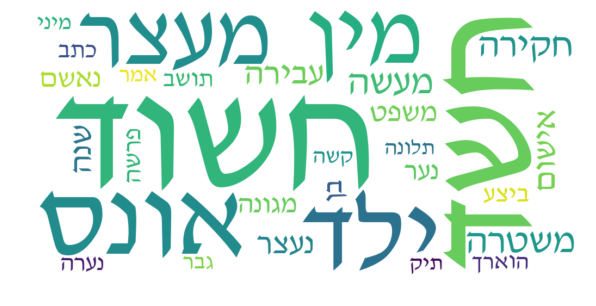

In [25]:
# build world cloud

### Option 1: Create word cloud from the word frequencies as found in the previous cell

def final_letter(word):
    '''A function that fixes the final letter of a word for the correct form
       because in Hebrew some letters are written differently in the end of a word'''
    if word.endswith('מ'):
        word = word[:-1]+'ם'

    elif word.endswith('כ'):
        word = word[:-1]+'ך'

    elif word.endswith('נ'):
        word = word[:-1]+'ן'

    elif word.endswith('פ'):
        word = word[:-1]+'ף'

    elif word.endswith('צ'):
        word = word[:-1]+'ץ'
        
    return word

bidi_dict = {} # new dictionary for reversed keys (words) for presentation
for k,v in sorted_words.items():
    bidi_dict[get_display(final_letter(k))] = v # get_display from the bidi library for chaning the order

# create wordcloud object
wc1 = WordCloud(background_color="white", width=1000, height=500,
                font_path='david.ttf', max_words=30, min_font_size=8, 
                normalize_plurals=False).generate_from_frequencies(bidi_dict)

##
### Option 2: Create word cloud from the entire norm_words column as a chunk
## 

# # create a long bulk of text from the entire norm_words column
# all_words = ' '.join(clean_df.norm_words.values)

# # words to exclude when counting - 'of', 'his', 'with', etc.
# stopwords = ['את',
#                'על',
#                'של',
#                'הוא',
#                'כי',
#                'לא',
#                'נגד',
#                'עמ',
#                'היה',
#                'זה',
#                'יומ',
#                'לאחר',
#                'בית', 
#                'בת', 
#                'כל']

# # convert text and words for left-to-write presentation
# bidi_text = get_display(all_words)
# bidi_stop = {get_display(w) for w in stopwords}

# create figure
plt.figure(figsize=(12,6))

# ### create word cloud object
# wc2 = WordCloud(background_color="white", width=1000, height=500,
#                font_path='david.ttf', stopwords=bidi_stop, max_words=30, 
#                min_font_size=8, normalize_plurals=False, regexp=None).generate_from_text(bidi_text)


# plot both
#plt.subplot(1,2,1)
plt.figure(figsize=(10,5))
#plt.title('From word frequncies')
plt.imshow(wc1, interpolation='bilinear')
plt.axis("off")

# plt.subplot(1,2,2)
# plt.title('From raw text column')
# plt.imshow(wc2, interpolation='bilinear')
# plt.axis("off")

plt.show()

In [26]:
sum(clean_df.norm_words.str.count('אונס')), sorted_words['אונס']

(112, 112)

#### Comments
There are two options above - cloud from the raw text and from the word frequencies function. Looks like for some reason the raw text column word cloud is not accurate, because the frequency dictionary correctly identified the number of mentions of a word (rape - 112 above), but it was tiny when building the cloud with raw text. So I'm using the dictionary above.
 
The main thing that stands out here is that most words revolve around the criminal aspect of sexual assault: the largest ones (except for rape, 3rd most common) are suspect (male), allegations, child, arrest, sex, police, investigation, violation, criminal charges. These are followed by arrested, trial, defendant, criminal record. Given that this is just the titles, perhaps it's reasonable that criminal-legal terminology is there? Would it be better if there was more focus on the victim and what happened to here rather than reporting on the suspect first? Not sure.

To say something meaningful about the use of lenient terms that are not rape when it is a potential rape case will probably be hard - the cases that do not use this word will have to be looked quite closely, and I doubt I'll have some automated word-based way of knowing. 

### 2. Lawyer mentions 
How much space is given to lawyers, and what messages are highlighted by featuring them?

In [27]:
legal = ['עורכ דינ',
        'ערכ דינ',
        #'פרקליט', removed because of praklitut spam
        'סנגור',
        'עו"ד']


# find number of legal words in each article
legal_words = clean_df['norm_words'].str.count('|'.join(legal))

print(f'Articles with some legal reference: {sum(legal_words > 0)} of {clean_df.shape[0]} articles')

Articles with some legal reference: 27 of 214 articles


In [45]:
# look at the content of these articles - a lot around one case of the 7yo and cyprus, 
# did not address them below because these were longer stories and both sides had different items

legal_indices = clean_df.index[legal_words>0].tolist()
for i in legal_indices:
    print(i, '\n', new_df.title.values[i] ,'\n', new_df.subtitle.values[i])

#### Comments
Strong negative examples of bad practices: 1643, 2307, 2626, 2814

'He denies' but no voice for the victim: 1149, 1826, 2233, 2606, 2821, 3719, 3800, 4019, 4132

The lawyer of the victim: 1794, 1854, 1564, 2605, 2621, 3751, 3917

It appears to me that this part has the potential to feature some examples of the different types of coverage rather than perform some quantitative analysis on number of mentions etc. Show some examples were the victim's voice was highlighted and others that focused on the defendant, from 'denial' to worse ('he could not stop himself'... jesus). I might try to quantify this ratiom, but it might take some work and I'm not sure how strong will it be.

Maybe I could try to use these references to find what the lawyers are saying every time (if only they would always put it in quotation marks...) - then it would be easier to analyze these for the above questions. 

### 3. Gendered verbs - what did both sides do?

#### A. Look at one article

In [29]:
# find all verbs in a given row (title+subtitle)
row_id = 11 # the row to look at

# a long string and an array of words for that row
original_text = clean_df.title.values[row_id]+' '+clean_df.subtitle.values[row_id]
original_words = original_text.split(' ')

# get result from API
request = {'token': 'EGxhAVjlYSoRNsN', 'readable': False,
           'paragraph':  original_text}

result = requests.post('https://hebrew-nlp.co.il/service/Morphology/Analyze', json=request).json()

# array to store rows for a little dataframe that shows the 
# verb, gender, and sentence context to look at results closely
verbs=[]
word_id = 0

# iterate over all words in the result
for sentence in result:
     for word in sentence:
        best_option = word[0] # get the best-guess normalized word 
        if len(best_option['baseWord']) <= 1: # ignore punctuation
            continue
            
        if best_option['partOfSpeech'] == 'VERB':
            new_verb = { # create a new row
                'normalized' : best_option['baseWord'], # the verb
                'gender': best_option['gender'], # the gender
                'context': (' ').join(original_words[ # context in sentence
                    max(0,word_id-3):min(word_id+3, len(original_words))])
                }
            
            # add the suffix for feminine verbs for easy read
            if new_verb['gender']=='FEMALE' and new_verb['normalized'][-1]!='ה':
                new_verb['normalized'] = new_verb['normalized']+'ה'
            verbs.append(new_verb)
        word_id+=1

pd.DataFrame(verbs) 

,normalized,gender,context
0,הרס,MALE,''הרס לי את
1,הוגשה,FEMALE,עבירות מין הצהרת תובע הוגשה נגד
2,היה,FEMALE,"לפני 20 שנה, מאז שהייתה בת"
3,אירע,MALE,"החשד, לפחות אחד המקרים אירע בחדר"


#### Comments 
1. One complication is that even though with adults 99% of cases have a male perpetrator and female victim, with children victims (which are, unfortunately, a subset of cases) there are some male victims, and more rarely, female perpetrators. I might try to count exactly how many of such cases to understand if it's significant or just stands out most clearly.
2. Verbs can sometimes be associated with lawyers, police, court (praklitut) - makes it harder. Although these might even out - some of these are masculine and some feminine. maybe i'll have to count these to make sure it does. not sure it's THAT worth it.
3. Misidentifications by the linguistic analyzer - the word for lawyer has an embedded verb in it. Can be removed after when looking at the list, though. I don't think I'll do anything else except for that + acknowledging it. It doesn't look like it happens very often.
4. If there are multiple offenders, the verb comes up as 'both' because it's not gendered in plural. So that's one reason to think that the male verbs results actually underestimate the true numbers. 

#### 3B. Find verbs in all articles

In [31]:
def get_all_terms(original_text, partOfSpeech):
    ''' Takes in the entire title+subtitle columns as a long string, and the part of speech to search of
        Returns to arrays, one for each gender, of the part of speech desired (e.g. verb)'''
    
    # array to hold results
    all_m_verbs, all_f_verbs = [], []
    
    for i in tqdm(range(len(original_text))):
        # get a result from API
        request = {'token': 'EGxhAVjlYSoRNsN', 'readable': False,
                   'paragraph':  original_text[i]}

        result = requests.post('https://hebrew-nlp.co.il/service/Morphology/Analyze', json=request).json()

        # arrays to store verbs
        row_m_verbs=[]
        row_f_verbs=[]

        # iterate over all words in the result
        for sentence in result:
             for word in sentence:
                best_option = word[0] # get the best-guess normalized word 
                if len(best_option['baseWord']) <= 1: # ignore punctuation
                    continue

                if best_option['partOfSpeech'] == partOfSpeech: # if a verb, add to respective array
                    if best_option['gender'] =='MALE':
                        row_m_verbs.append(best_option['baseWord'])

                    # add the suffix for feminine verbs for easy read
                    elif best_option['gender'] =='FEMALE':
                        row_f_verbs.append(best_option['baseWord']+'ה')

        all_m_verbs.append(' '.join(row_m_verbs))
        all_f_verbs.append(' '.join(row_f_verbs))
        
    return all_m_verbs, all_f_verbs

# a joint string for title and subtitle
original_text = clean_df.title.values+' '+clean_df.subtitle.values

# array to store two new columns: all masculine/feminene verbs in the article
all_m_verbs, all_f_verbs = get_all_terms(original_text, 'VERB')

100%|██████████| 214/214 [00:40<00:00,  5.35it/s]


In [32]:
# optionally, add that to the df as a column
# clean_df.loc[:,'m_verbs'] = all_m_verbs
# clean_df.loc[:,'f_verbs'] = all_f_verbs

# get a sorted version of verb occurences 
def get_sorted_counts(all_verbs):
    '''Takes in an array of strings that contain all verbs separated by whitespaces
    returns a sorted count dictionary across all elements in the input array'''
    verbs_counts= {} # holds the result

    # for each collection of words in a title+subtitle
    for wrds in all_verbs: 
        # create a count dictionary for it 
        keys, values = np.unique(wrds.split(' '), return_counts=True)
        temp_dict = dict(zip(keys, values))

        # add it to the total counter 'word_counts'
        verbs_counts = {key: verbs_counts.get(key, 0) + temp_dict.get(key, 0)
              for key in set(verbs_counts) | set(temp_dict)}

    verbs_counts.pop('') # remove an empty entry that gets created
    sorted_ = sorted(verbs_counts.items(), key=lambda x: x[1], reverse=True) # sort by frequency
    return(sorted_)

# get for male and female
m_sorted=np.array(get_sorted_counts(all_m_verbs))
f_sorted=np.array(get_sorted_counts(all_f_verbs))

In [33]:
# remove verbs that clearly do not talk about either person - marked by index
m_remv = [1, 2, 10, 15, 18]
f_remv = [1, 3, 7, 9, 13, 14, 15]

# remove by index and covert to the same format - np array with elements (verb, count) 
m_sorted = np.array([(i[0],i[1]) for j, i in enumerate(m_sorted) if j not in m_remv])
f_sorted = np.array([(i[0],i[1]) for j, i in enumerate(f_sorted) if j not in f_remv])

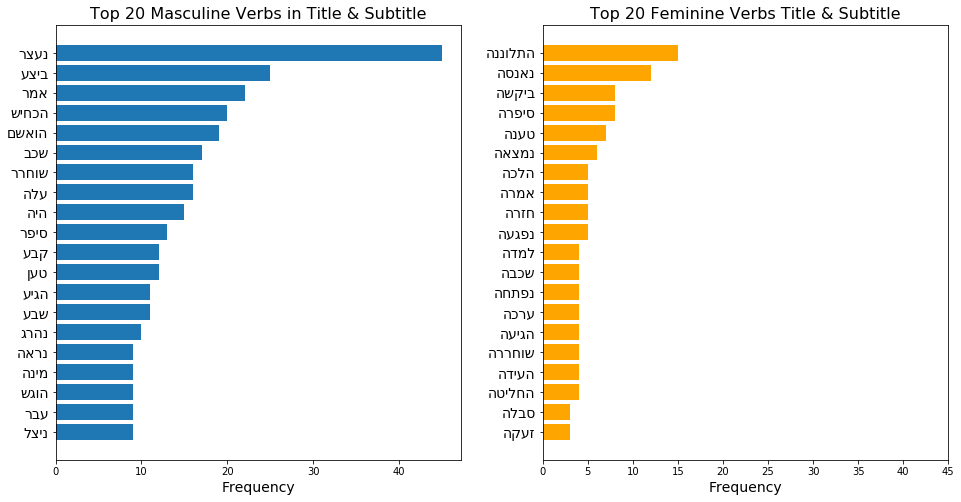

In [41]:
# print bar plots

# select top 20
topN = 20

# make lists with the verbs and frequencies
m_verbs = [get_display(final_letter(_)) for _ in m_sorted[:topN,0]]
m_counts = m_sorted[:topN,1].astype(int)

f_verbs = [get_display(final_letter(_)) for _ in f_sorted[:topN,0]]
f_counts = f_sorted[:topN,1].astype(int)

fig, (ax1,ax2) = plt.subplots(1, 2, figsize=(16,8))

# masculine
ax1.barh(np.arange(len(m_verbs)), m_counts)
ax1.set_yticklabels(m_verbs, fontsize=14)
ax1.set_yticks(np.arange(len(m_verbs)))
ax1.invert_yaxis()  # labels read top-to-bottom
ax1.set_xlabel('Frequency', fontsize=14)
ax1.set_title('Top 20 Masculine Verbs in Title & Subtitle', fontsize=16)

# feminine
ax2.barh(np.arange(len(f_verbs)), f_counts, color='orange')
ax2.set_xlim(0,max(m_counts))
ax2.set_yticklabels(f_verbs, fontsize=14)
ax2.set_yticks(np.arange(len(f_verbs)))
ax2.invert_yaxis()  # labels read top-to-bottom
ax2.set_xlabel('Frequency', fontsize=14)
ax2.set_title('Top 20 Feminine Verbs Title & Subtitle', fontsize=16)
plt.show()

In [42]:
# number of verbs per category
sum(m_sorted[:,1].astype(int)), sum(f_sorted[:,1].astype(int))

(918, 349)